# Imports

In [2]:
import collections
import cv2
import functools
import imageio
import os
import sys
from datetime import datetime
from typing import Callable, Optional

if "PyTorch_VAE" not in sys.path:
    sys.path.append("PyTorch_VAE")

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from tqdm.notebook import tqdm, trange

from diffusion_policy.dataset.pusht_image_dataset import PushTImageDataset
from diffusion_policy.model.diffusion import conditional_unet1d
from diffusion_policy.env.pusht.pusht_image_env import PushTImageEnv
from inverse_dynamics import InverseDynamicsCNN
from state_diffusion import Diffusion, sample
from utils import (
    normalize_pn1,
    normalize_standard_normal,
    denormalize_img,
    denormalize_pn1,
    denormalize_standard_normal,
)
from vae import VanillaVAE

In [3]:
def create_gif(image_arrays, filename, duration=0.1):
    """
    Create a GIF from a list of NumPy array images.

    Parameters:
        image_arrays (list of np.ndarray): List of NumPy array images.
        filename (str): Filename for the output GIF.
        duration (float): Duration (in seconds) of each frame in the GIF.

    Returns:
        None
    """
    images = []
    for image_array in image_arrays:
        # Ensure that the image array is in uint8 format
        image_array = np.uint8(image_array)
        images.append(image_array)

    # Write the images to a GIF file
    with imageio.get_writer(filename, mode='I', duration=duration) as writer:
        for image in images:
            writer.append_data(image)


# Args

In [4]:
device = "cuda"
data_path = (
    "/nas/ucb/ebronstein/lsdp/diffusion_policy/data/pusht/pusht_cchi_v7_replay.zarr"
)

# VAE
vae_path = "models/pusht_vae/vae_32_20240403.pt"
vae_latent_dim = 32

# Diffusion
diffusion_load_dir = "models/diffusion/pusht_unet1d_img_128_256_512_1024_edim_256_obs_8_pred_8_bs_256_lr_0.0003_e_250_ema_norm_latent_uniform/2024-05-06_01-09-27"
n_obs_history = 8
n_pred_horizon = 8
diffusion_step_embed_dim = 256
normalize_latent = "uniform"
use_ema_helper = True
lr = 3e-4

# Inverse dynamics
inv_dyn_path = "models/inverse_dynamics/pusht_cnn-img-obs_5-bs_256-lr_0.0001-epochs_10-train_on_recon-False-latent_dim_32/2024-05-06_17-04-08/inverse_dynamics_final.pt"
inv_dyn_n_obs_history = 5

# Load dataset

In [5]:
dataset = PushTImageDataset(data_path)

In [7]:
dataset.replay_buffer["img"].shape

(25650, 96, 96, 3)

# Load models

In [4]:
# Load the VAE
img_data = (
    torch.from_numpy(dataset.replay_buffer["img"]).permute(0, 3, 1, 2).float()
)
N, C, H, W = img_data.shape
vae = VanillaVAE(in_channels=C, in_height=H, in_width=W, latent_dim=vae_latent_dim).to(
    device
)
vae.load_state_dict(torch.load(vae_path))

<All keys matched successfully>

In [5]:
# Load the diffusion model.
if n_pred_horizon == 1:
    down_dims = [128, 256]
elif n_pred_horizon == 4:
    down_dims = [128, 256, 512]
elif n_pred_horizon == 8:
    down_dims = [128, 256, 512, 1024]
else:
    raise NotImplementedError()

STATE_DIM = vae_latent_dim
global_cond_dim = STATE_DIM * n_obs_history
diff_model = conditional_unet1d.ConditionalUnet1D(
    input_dim=STATE_DIM,
    down_dims=down_dims,
    diffusion_step_embed_dim=diffusion_step_embed_dim,
    global_cond_dim=global_cond_dim,
).to(device)

# Make the observation normalizer.
if normalize_latent == "uniform":
    latent_min = np.load(os.path.join(diffusion_load_dir, "latent_min.npy"))
    latent_max = np.load(os.path.join(diffusion_load_dir, "latent_max.npy"))
    obs_normalizer = functools.partial(
        normalize_pn1,
        min_val=torch.tensor(latent_min, dtype=torch.float32, device=device),
        max_val=torch.tensor(latent_max, dtype=torch.float32, device=device),
    )
elif normalize_latent == "standard_normal":
    latent_mean = np.load(os.path.join(diffusion_load_dir, "latent_mean.npy"))
    latent_std = np.load(os.path.join(diffusion_load_dir, "latent_std.npy"))
    obs_normalizer = functools.partial(
        normalize_standard_normal,
        mean=torch.tensor(latent_mean, dtype=torch.float32, device=device),
        std=torch.tensor(latent_std, dtype=torch.float32, device=device),
    )
else:
    raise NotImplementedError()

optim_kwargs = dict(lr=lr)
diffusion = Diffusion(
    train_data=None,
    test_data=None,
    obs_normalizer=obs_normalizer,
    model=diff_model,
    n_epochs=0,
    optim_kwargs=optim_kwargs,
    device=device,
    use_ema_helper=use_ema_helper,
)
diffusion.load(os.path.join(diffusion_load_dir, "diffusion_model_final.pt"))

In [6]:
# Load the inverse dynamics model.

hidden_dims = None
N, H, W, C = dataset.replay_buffer["img"].shape
N, action_dim = dataset.replay_buffer["action"].shape
inv_dyn_model = InverseDynamicsCNN(
    C, H, W, action_dim, inv_dyn_n_obs_history, hidden_dims=hidden_dims
).to(device)

inv_dyn_model.load_state_dict(torch.load(inv_dyn_path))

<All keys matched successfully>

# Run the env

In [76]:
# Number of actions predicted.
pred_horizon = 8
# Number of observations in the history.
obs_horizon = 8
# Number of actions executed open-loop.
action_horizon = 1
action_dim = 2

# |o|o|                             observations: 2
# | |a|a|a|a|a|a|a|a|               actions executed: 8
# |p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# 0. create env object
env = PushTImageEnv()

# 1. seed env for initial state.
# Seed 0-200 are used for the demonstration dataset.
seed = 0
env.seed(seed)

# 2. must reset before use
obs = env.reset()

# 3. 2D positional action space [0,512]
action = env.action_space.sample()

# 4. Standard gym step method
obs, reward, terminated, truncated = env.step(action)

# prints and explains each dimension of the observation and action vectors
with np.printoptions(precision=4, suppress=True, threshold=5):
    print("obs['image'].shape:", obs["image"].shape, "float32, [0,1]")
    print("obs['agent_pos'].shape:", obs["agent_pos"].shape, "float32, [0,512]")
    print("action.shape: ", action.shape, "float32, [0,512]")

obs['image'].shape: (3, 96, 96) float32, [0,1]
obs['agent_pos'].shape: (2,) float32, [0,512]
action.shape:  (2,) float32, [0,512]


In [77]:
# Action normalization functions.
denormalize_action = functools.partial(
    denormalize_pn1,
    min_val=torch.tensor(env.action_space.low, dtype=torch.float32, device=device),
    max_val=torch.tensor(env.action_space.high, dtype=torch.float32, device=device),
)

In [90]:
assert action_horizon == 1, "Only action_horizon=1 is supported."

# limit environment interaction to 200 steps before termination
max_steps = 15
# Number of diffusion samples per step for rejection sampling.
num_samples_per_step = 64

# keep a queue of last obs_horizon steps of observations
obs_deque = collections.deque([obs], maxlen=obs_horizon)
# save visualization and rewards
imgs = [env.render(mode="rgb_array")]
rewards = list()
done = False
step_idx = 0

# Future images predicted by the diffusion model.
npred_list = []
# Observation history images.
images_list = []
# Actions predicted by the inverse dynamics model.
actions_list = []
# Observation history images reconstructed by the VAE.
images_recon_list = []

with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
    iter = 0
    while not done:
        B = 1
        # stack the last obs_horizon number of observations
        # Range: [0, 1]
        images = np.stack([x["image"] for x in obs_deque])  # [obs_horizon, 3, 96, 96]
        assert images.min() >= 0 and images.max() <= 1
        images_list.append(images)
        # Range: [0, 512]
        agent_poses = np.stack([x["agent_pos"] for x in obs_deque])  # [obs_horizon, 2]
        assert agent_poses.min() >= 0 and agent_poses.max() <= 512

        # normalize observation
        # double check this
        nagent_poses = agent_poses / 512.0 * 2 - 1  # [-1, 1]
        assert nagent_poses.min() >= -1 and nagent_poses.max() <= 1

        # images are normalized to [0,1], in the environment
        nimages = images * 2 - 1  # [-1, 1.]
        assert nimages.min() >= -1 and nimages.max() <= 1

        # device transfer
        nimages = torch.from_numpy(nimages).to(device, dtype=torch.float32)
        # (2,3,96,96)

        with torch.no_grad():
            # Encode images with the VAE.
            # TODO: just use vae.encode instead.
            nimages_recon, _, obs_latents, _ = vae(nimages)
            print("nimages_recon:", nimages_recon.shape)
            assert nimages_recon.min() >= -1 and nimages_recon.max() <= 1
            # Denormalize the reconstructed images.
            images_recon = denormalize_img(nimages_recon)
            images_recon_list.append(images_recon.cpu().numpy())
            # obs_latents = vae.encode(nimages)[0]
            obs_latents = obs_latents.repeat(num_samples_per_step, 1, 1)
            # print("obs_latents:", obs_latents.shape)
            # print("obs_latents.min():", obs_latents.min())
            # print("obs_latents.max():", obs_latents.max())

            # No need to normalize the VAE latents here because we do so in
            # the sample functions.
            # # Range: [-1, 1]
            # nobs_latents = obs_normalizer(obs_latents)
            # assert nobs_latents.min() >= -1 and nobs_latents.max() <= 1

        if images.shape[0] < n_obs_history:
            # Sample a random action if we don't have enough observations.
            action = env.action_space.sample()
        else:
            # Sample from the diffusion model.
            with torch.no_grad():
                rejection_sample_count = 0
                while True:
                    # [len(return_steps), num_samples, n_pred_horizon, latent_dim] and
                    # [len(return_steps), num_samples, n_obs_history, latent_dim)]
                    npred_latents, _ = sample(
                        diffusion,
                        num_samples=num_samples_per_step,
                        return_steps=[512],
                        data_shape=(n_pred_horizon, STATE_DIM),
                        obs_data=obs_latents,
                        obs_normalizer=obs_normalizer,
                        clip=None,
                        clip_noise=(-3, 3),
                        device=device,
                        obs_key=None,  # Unused because obs_data is not a dataloader.
                    )
                    # print("npred_latents:", npred_latents.shape)
                    # print("npred_latents.min()", npred_latents.min())
                    # print("npred_latents.max()", npred_latents.max())
                    # [num_samples, n_pred_horizon, latent_dim]
                    npred_latents = npred_latents.squeeze(0)
                    # print("npred_latents:", npred_latents.shape)

                    if normalize_latent == "uniform":
                        # Remove samples that are out of the range [-1, 1].
                        mask = ((npred_latents >= -1) & (npred_latents <= 1)).all(
                            axis=(-1, -2)
                        )
                        # Range: [-1, 1] (for real now)
                        if mask.sum() > 0:
                            # [n_in_range_samples, n_pred_horizon, latent_dim]
                            in_range_npred_latents = npred_latents[mask]
                            # print("in_range_npred_latents:", in_range_npred_latents.shape)
                            break
                        print(
                            f"Attempt {rejection_sample_count + 1}: mo samples in range."
                        )
                    else:
                        in_range_npred_latents = npred_latents
                        break

                    rejection_sample_count += 1

                # Denormalize using the latents statistics.
                if normalize_latent == "standard_normal":
                    # Range: [-1, 1]
                    in_range_pred_latents = denormalize_standard_normal(
                        in_range_npred_latents, latent_mean, latent_std
                    )
                elif normalize_latent == "uniform":
                    # Range: [latent_min, latent_max]
                    in_range_pred_latents = denormalize_pn1(
                        in_range_npred_latents, latent_min, latent_max
                    )
                    assert (latent_min < latent_max).all()
                    assert (
                        in_range_pred_latents.min(axis=(0, 1)) >= latent_min
                    ).all() and (
                        in_range_pred_latents.max(axis=(0, 1)) <= latent_max
                    ).all()
                else:
                    in_range_pred_latents = in_range_npred_latents
                # Decode using the VAE.
                # [n_in_range_samples * n_pred_horizon, C, H, W]
                # Range: [-1, 1]
                npred = vae.decode(torch.from_numpy(in_range_pred_latents).to(device))
                assert npred.min() >= -1 and npred.max() <= 1
                # [n_in_range_samples, n_pred_horizon, C, H, W]
                npred = npred.reshape([-1, n_pred_horizon] + list(npred.shape[1:]))
                npred_list.append(npred.cpu().numpy())
                # print("npred:", npred.shape)

                # Take the first sample prediction arbitrarily.
                npred = npred[0]  # [n_pred_horizon, C, H, W]
                # print("npred:", npred.shape)

                # Concatenate the last inv_dyn_n_obs_history - 1 observations with
                # the first predicted observation in order to get the action.
                # NOTE: this currently only works for action_horizon = 1.
                nobs_and_npred = torch.cat(
                    [nimages[-(inv_dyn_n_obs_history - 1) :], npred[:1]], dim=0
                )
                # nobs_and_npred = torch.cat([nimages[-(1):], npred[:(4)]], dim=0)
                # print("nobs_and_npred:", nobs_and_npred.shape)

                # NOTE: no need to denormalize the image because the inverse dynamics
                # model takes in a normalized image.

                # Run the inverse dynamics model.
                # [1, action_dim]
                nactions = inv_dyn_model(nobs_and_npred.unsqueeze(0))
                assert nactions.min() >= -1 and nactions.max() <= 1
                # print("nactions:", nactions.shape)
                # Denormalize the actions.
                # [1, action_dim]
                actions = denormalize_action(nactions)
                assert (
                    actions.min() >= env.action_space.low[0]
                    and actions.max() <= env.action_space.high[0]
                )
                # print("actions:", actions.shape)

        # nagent_poses = torch.from_numpy(nagent_poses).to(device, dtype=torch.float32)
        nagent_poses = nagent_poses
        # (2,2)

        # TODO: only take action_horizon number of actions
        # action = actions[:action_horizon, :]  # (action_horizon, action_dim)
        action = actions.cpu()  # (action_horizon = 1, action_dim)
        actions_list.append(action.numpy())

        # execute action_horizon number of steps
        # without replanning
        for i in range(len(action)):
            # stepping env
            obs, reward, done, _ = env.step(action[i])
            # save observations
            obs_deque.append(obs)
            # and reward/vis
            rewards.append(reward)
            imgs.append(env.render(mode="rgb_array"))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break

        iter += 1

# print out the maximum target coverage
print("Score: ", max(rewards))

# visualize
# from IPython.display import Video
# vwrite('vis.mp4', imgs)
# Video('vis.mp4', embed=True, width=256, height=256)

Eval PushTImageEnv:   0%|          | 0/15 [00:00<?, ?it/s]

nimages_recon: torch.Size([1, 3, 96, 96])
nimages_recon: torch.Size([2, 3, 96, 96])
nimages_recon: torch.Size([3, 3, 96, 96])
nimages_recon: torch.Size([4, 3, 96, 96])
nimages_recon: torch.Size([5, 3, 96, 96])
nimages_recon: torch.Size([6, 3, 96, 96])
nimages_recon: torch.Size([7, 3, 96, 96])
nimages_recon: torch.Size([8, 3, 96, 96])
nimages_recon: torch.Size([8, 3, 96, 96])
nimages_recon: torch.Size([8, 3, 96, 96])
nimages_recon: torch.Size([8, 3, 96, 96])
nimages_recon: torch.Size([8, 3, 96, 96])
nimages_recon: torch.Size([8, 3, 96, 96])
nimages_recon: torch.Size([8, 3, 96, 96])
nimages_recon: torch.Size([8, 3, 96, 96])
nimages_recon: torch.Size([8, 3, 96, 96])
Score:  0.16468500813135795


In [91]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
create_gif(imgs, f"pusht_rollout_{seed}_{timestamp}.gif", duration=0.5)

In [35]:
# # Visualize

# # image_folder = 'images'
# video_name = 'video.avi'

# # images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# # frame = cv2.imread(os.path.join(image_folder, images[0]))
# height, width, layers = imgs[0].shape

# video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MJPG'), 0, 1, (width,height))

# for image in imgs:
#     video.write(image)

# # cv2.destroyAllWindows()
# video.release()

# Debug

In [92]:
len(images_list), len(images_recon_list), len(npred_list), len(actions_list)

(16, 16, 9, 16)

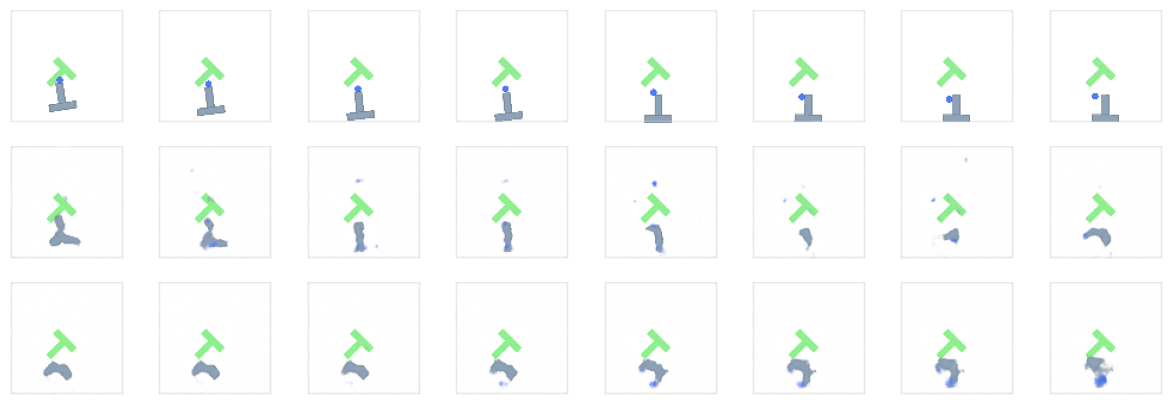

In [100]:
fig, axs = plt.subplots(3, n_obs_history, figsize=(15, 5), squeeze=False)

for i in range(n_obs_history, len(images_list)):
    # Real observation history images.
    obs_img = images_list[i + n_obs_history - 1]
    for j in range(n_obs_history):
        axs[0, j].axis("off")
        axs[0, j].imshow(obs_img[j].transpose(1, 2, 0))

    # Reconstructions of the observation history images.
    recon_img = images_recon_list[i + n_obs_history - 1] / 255.
    for j in range(n_obs_history):
        axs[1, j].axis("off")
        axs[1, j].imshow(recon_img[j].transpose(1, 2, 0))

    # Predicted future images by the diffusion model.
    npred = npred_list[i][0]
    pred = (npred + 1) / 2
    for k in range(pred.shape[0]):
        axs[2, k].axis("off")
        axs[2, k].imshow(pred[k].transpose(1, 2, 0))

    # for i in range(3):
    #     axs[i].axis("off")
    # axs[0].imshow(images[0].transpose(1, 2, 0))
    # axs[0].set_title("Observed")
    # axs[1].imshow(npred[0].transpose(1, 2, 0))
    # axs[1].set_title("Predicted")
    # axs[2].imshow(images[1].transpose(1, 2, 0))
    # axs[2].set_title("Next")
    plt.show()
    break

/tmp/ipykernel_1956750/115397443.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


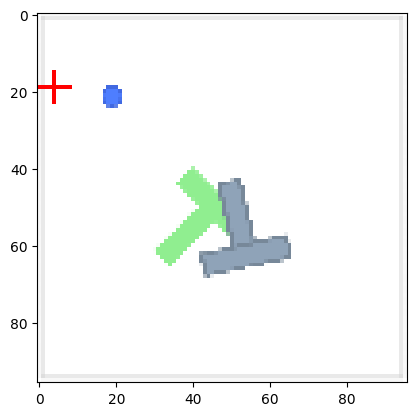

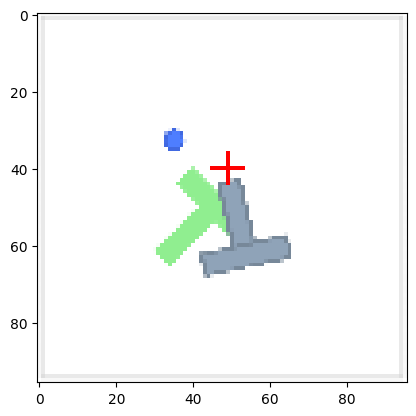

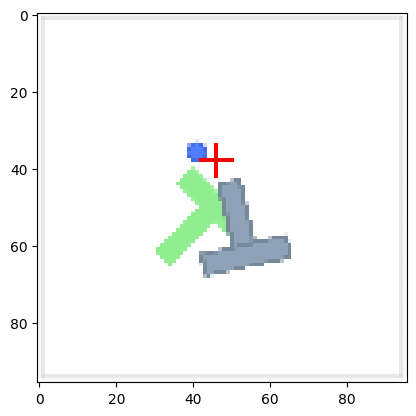

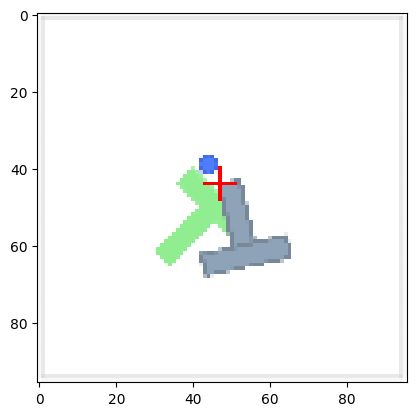

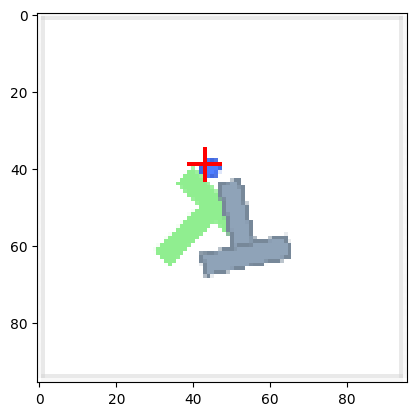

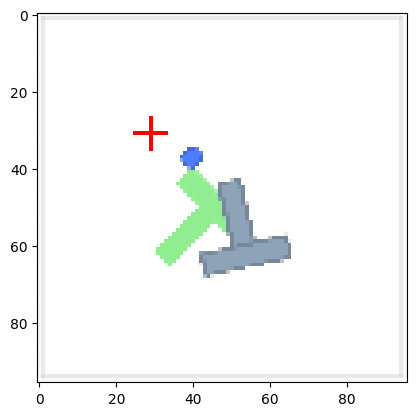

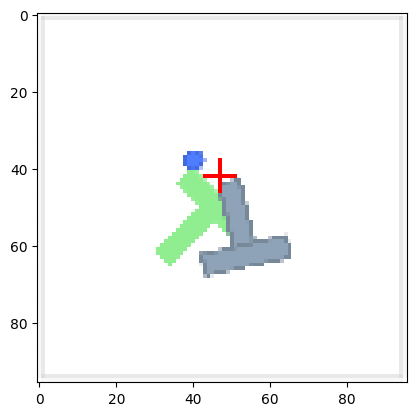

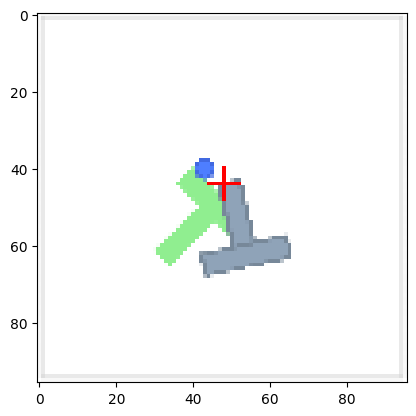

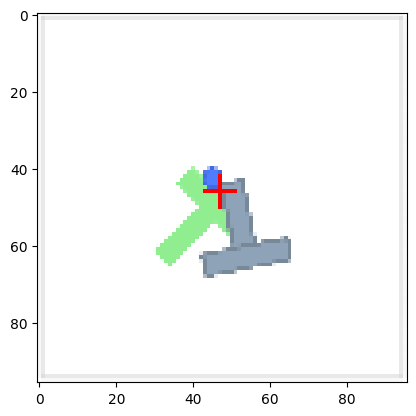

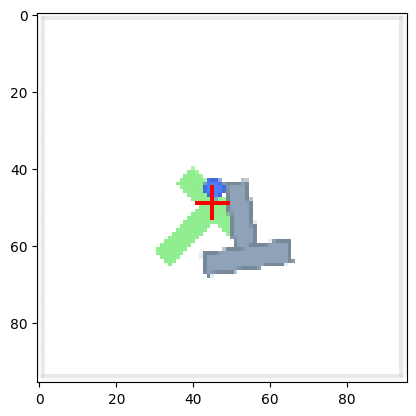

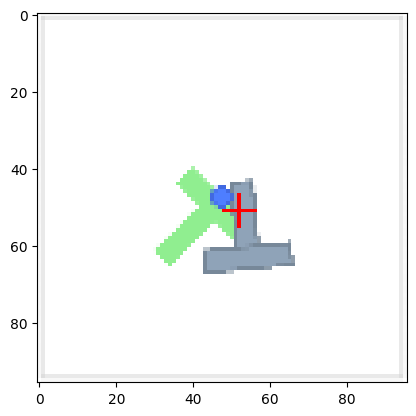

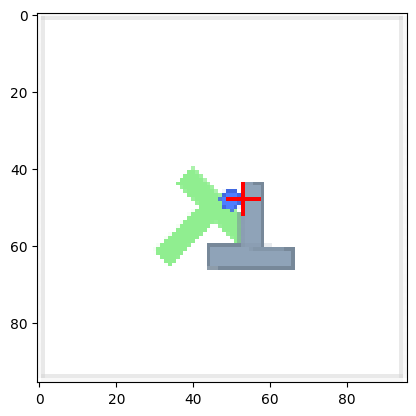

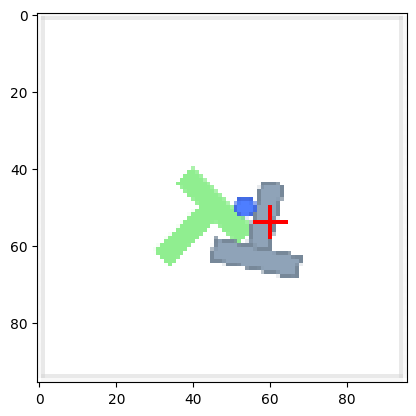

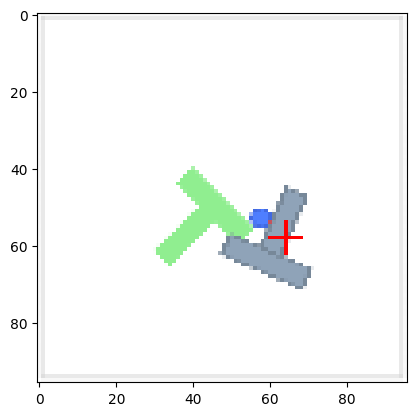

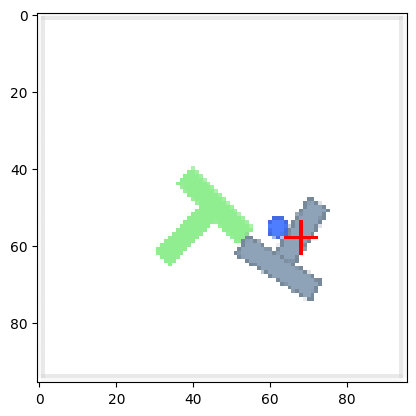

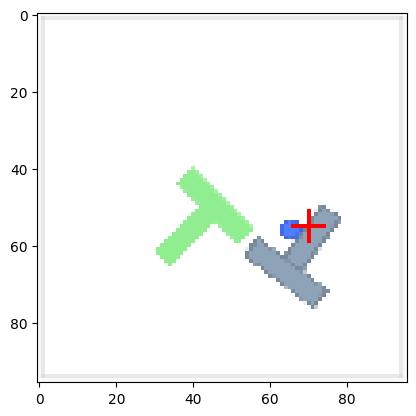

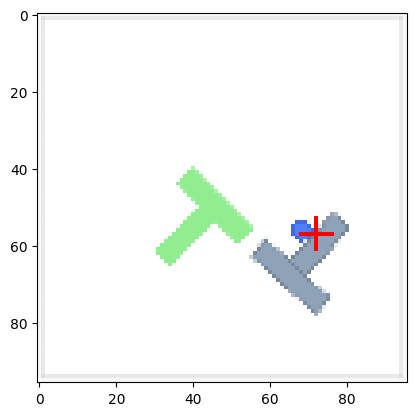

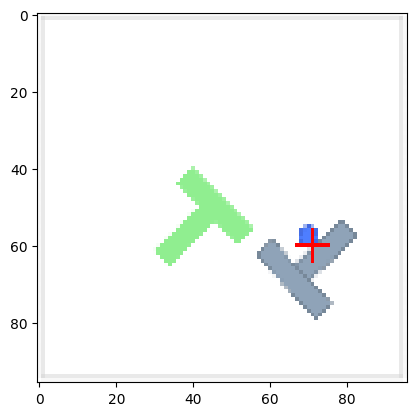

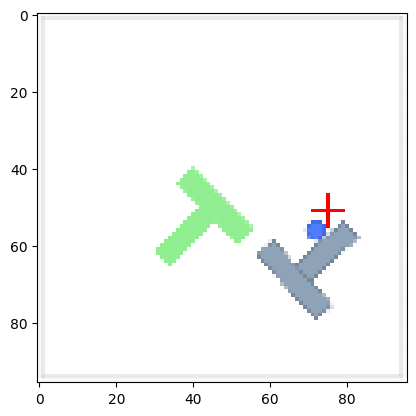

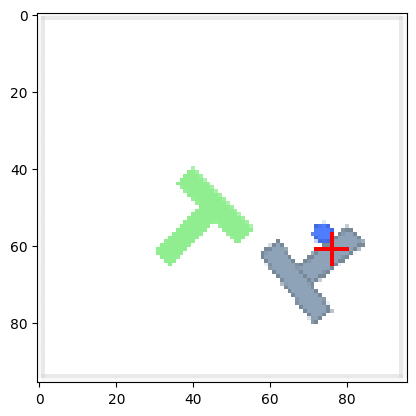

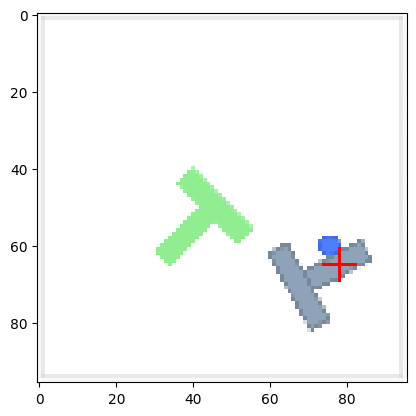

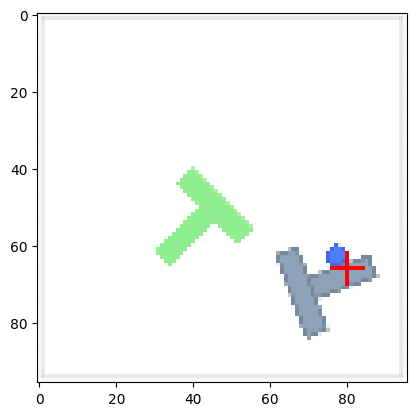

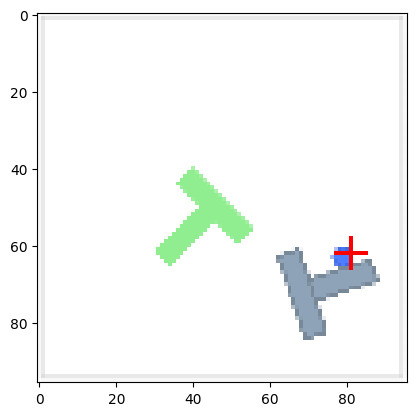

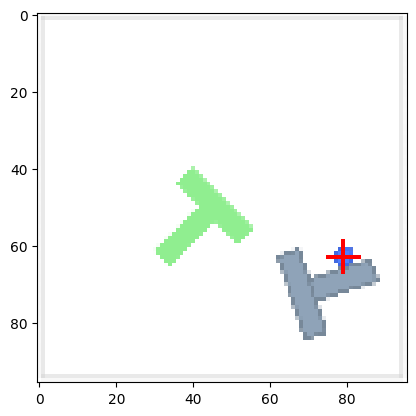

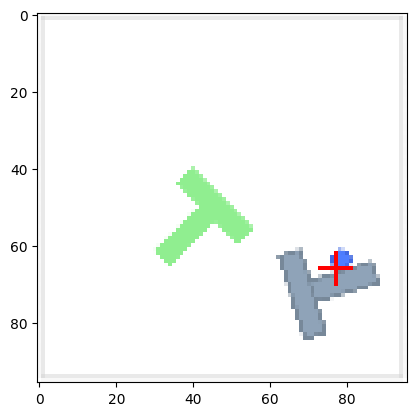

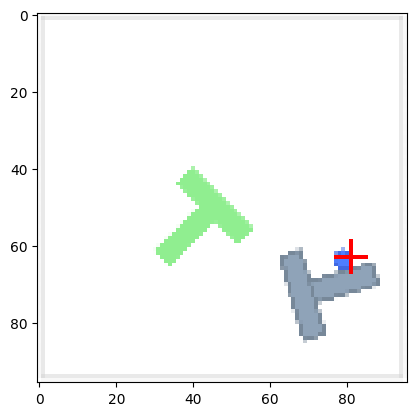

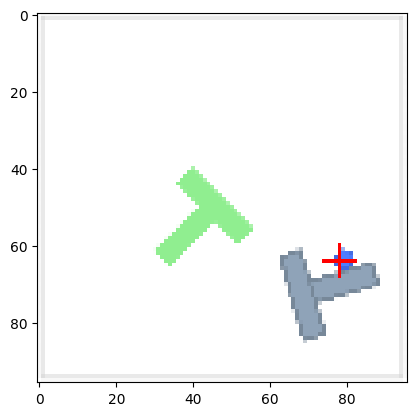

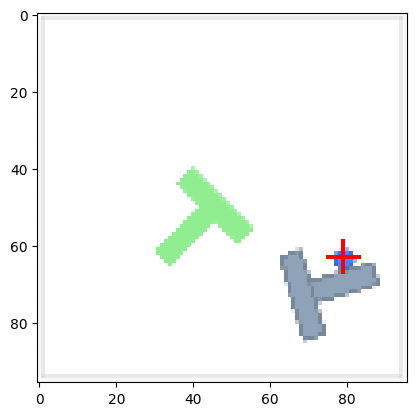

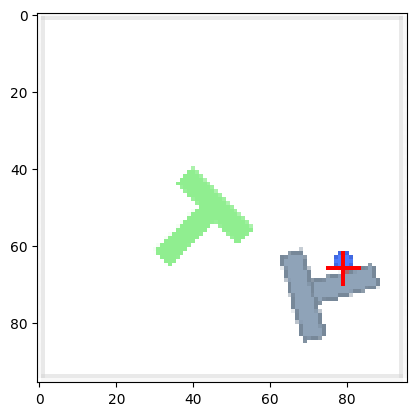

In [42]:
# fig, axs = plt.subplots(1, len(imgs), figsize=(16, 4 * len(imgs)))
for i, img in enumerate(imgs):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img)